In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prep_data import load_demo_data

data_obj = load_demo_data(".")

df_sales = data_obj.df_sales
funnel_cols = data_obj.funnel_variables

In [2]:
print(funnel_cols)

['transactions', 'items_per_transaction', 'income_per_item', 'profit_less_promotions_factor']


In [3]:
df_sales.head()

,store_nbr,report_date,sales,gross_profit,net_profit,transactions,items_per_transaction,income_per_item,profit_less_promotions_factor
2,1,2013-03-31,151666.227994,846639.222896,846639.222896,45299.0,3.348114,5.582253,1.0
3,1,2013-04-30,155848.493959,869212.493611,869212.493611,46740.0,3.334371,5.577292,1.0
4,1,2013-05-31,154965.652004,872140.064938,872140.064938,46286.0,3.348003,5.627957,1.0
5,1,2013-06-30,154051.426999,864108.873879,864108.873879,44876.0,3.432824,5.609223,1.0
6,1,2013-07-31,156757.218014,873687.809104,873687.809104,47874.0,3.274371,5.573509,1.0


# Comparing apples and oranges

From this point of view, it's difficult to understand what the overall contributors to the net profits are. Even breaking out the net profits to its own chart doesn't help much. We can clearly see some patterns, but how do we know what's driving the profits?

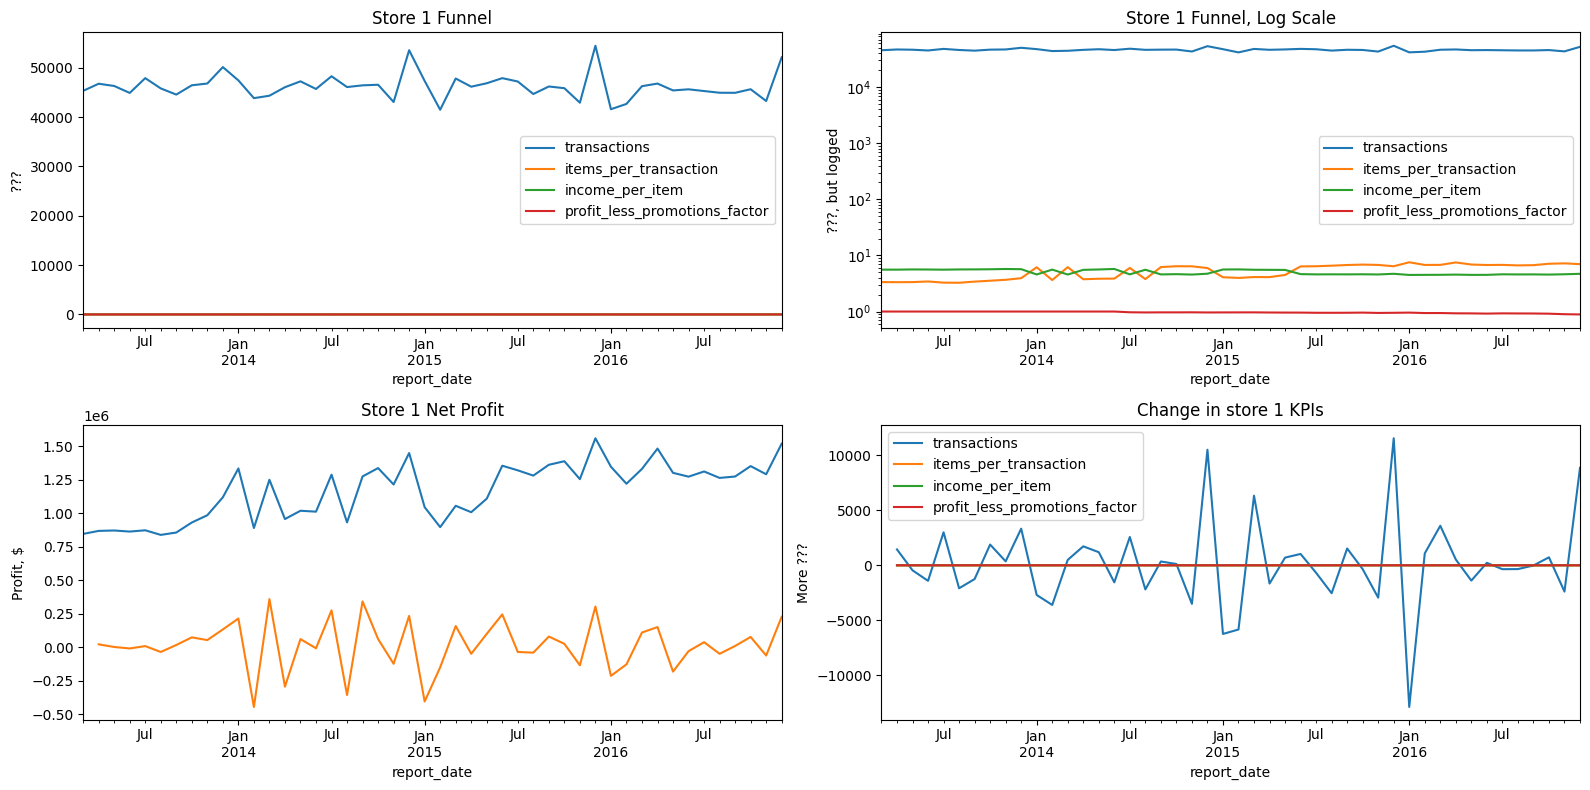

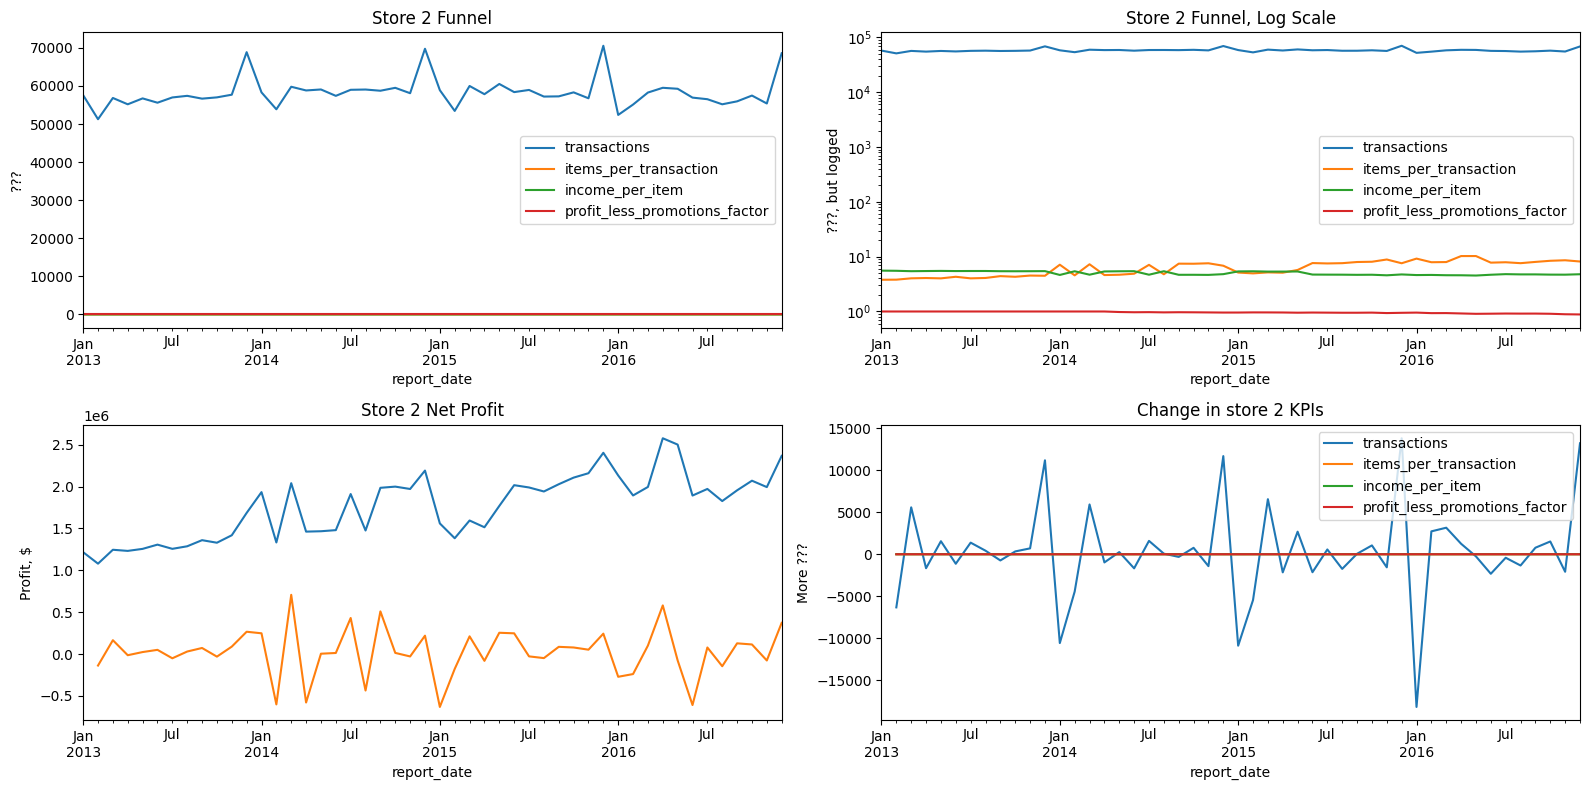

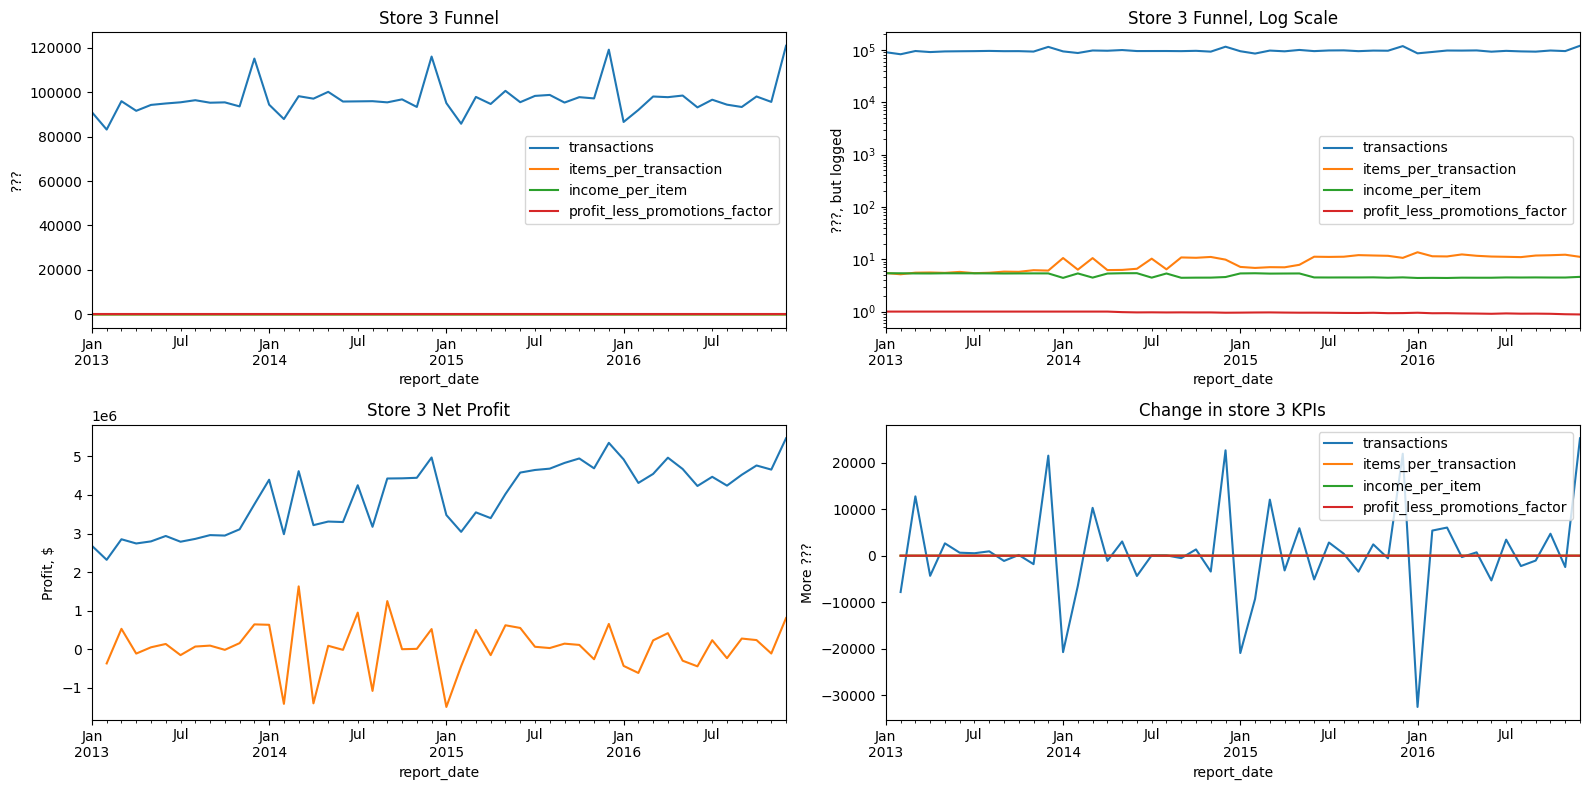

In [4]:
for store in range(1, 4):
    fig, ax = plt.subplots(2, 2, figsize=(16, 8))
    tmp = df_sales[df_sales.store_nbr == store].set_index("report_date")

    ax[0, 0].set_title(f"Store {store} Funnel")
    ax[0, 0].set_ylabel("???")
    tmp[funnel_cols].plot(ax=ax[0, 0])

    ax[0, 1].set_title(f"Store {store} Funnel, Log Scale")
    ax[0, 1].set_ylabel("???, but logged")
    tmp[funnel_cols].plot(ax=ax[0, 1])

    ax[0, 1].set_yscale("log")

    ax[1, 0].set_title(f"Store {store} Net Profit")
    ax[1, 0].set_ylabel("Profit, $")
    tmp["net_profit"].plot(ax=ax[1, 0])
    tmp["net_profit"].diff().plot(ax=ax[1, 0], label="Change in profit")
    ax[1, 0].legend()

    ax[1, 1].set_title(f"Change in store {store} KPIs")
    ax[1, 1].set_ylabel("More ???")
    tmp[funnel_cols].diff().plot(ax=ax[1, 1])

    fig.tight_layout()
    plt.show()

# Metric Decomposition

Because our KPI is expressable as a product of other KPIs, we can decompose it into its constituent parts. This is a common technique in business analysis, and it's called metric decomposition. One of the nicest things about this technique is that it denominates your funnel into constituent contributions to the top-level KPI, _denominated in the same units as the KPI itself_. This makes it easy to compare the relative contributions of each part of the funnel.

As a bonus, this technique is sufficiently flexible that that it can be applied to (almost) any KPI, no matter how complex. The major downside is we can't get "contribution at a point in time, unless our data runs all the way back to the beginning of the data. We can approximate this by adding the t=0 value to the decomposition, or by being okay with an approximate method.

Here, we apply the technique to the above data, and we can see that the biggest driver for these stores is the number of transactions. No surprise, sure, but we can very much see the magnitude of the effect. It would also allow us to directly assess if e.g. losses due to a change in promotions strategy is driving a corresponding increase in other metrics such as average transaction value.

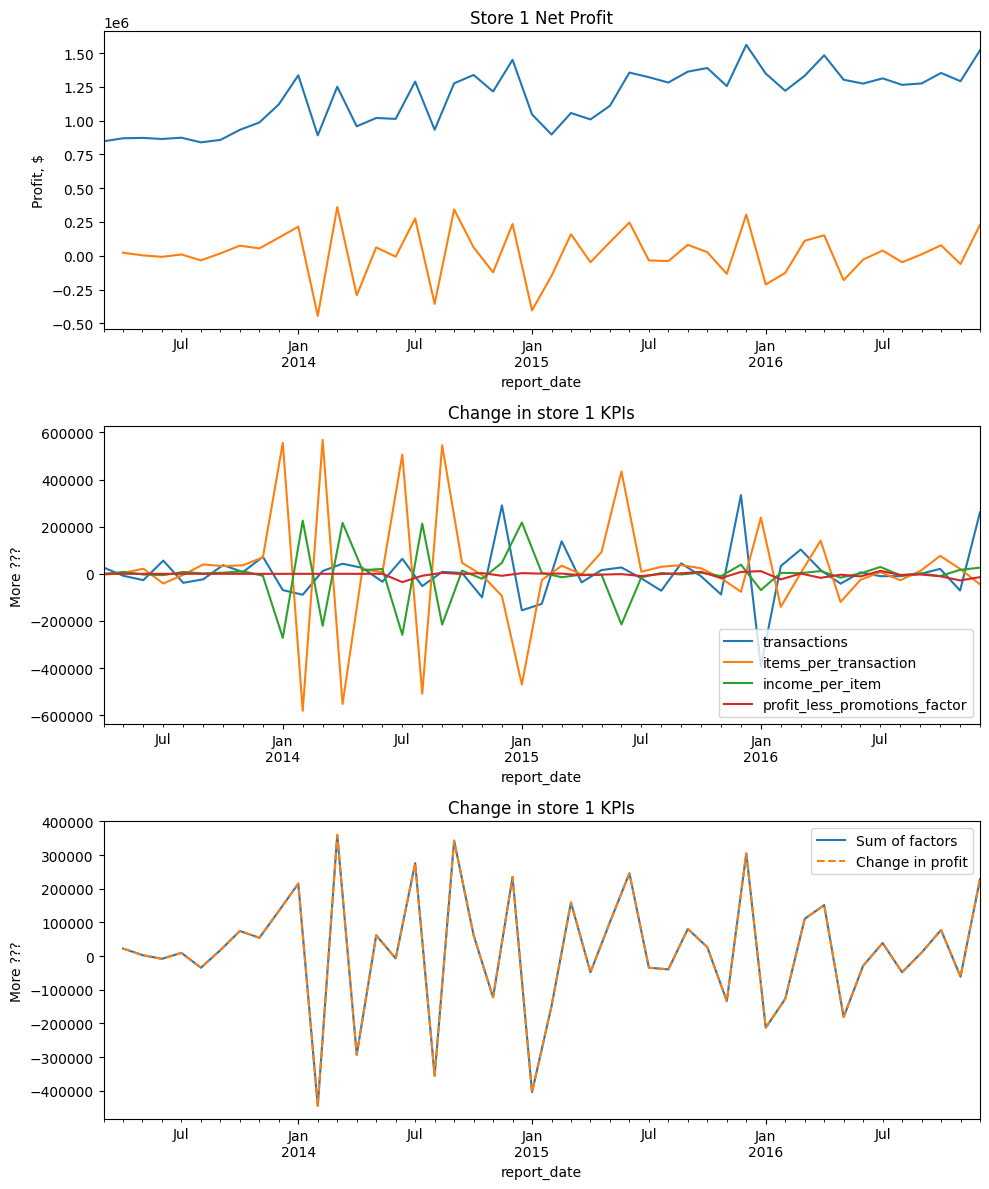

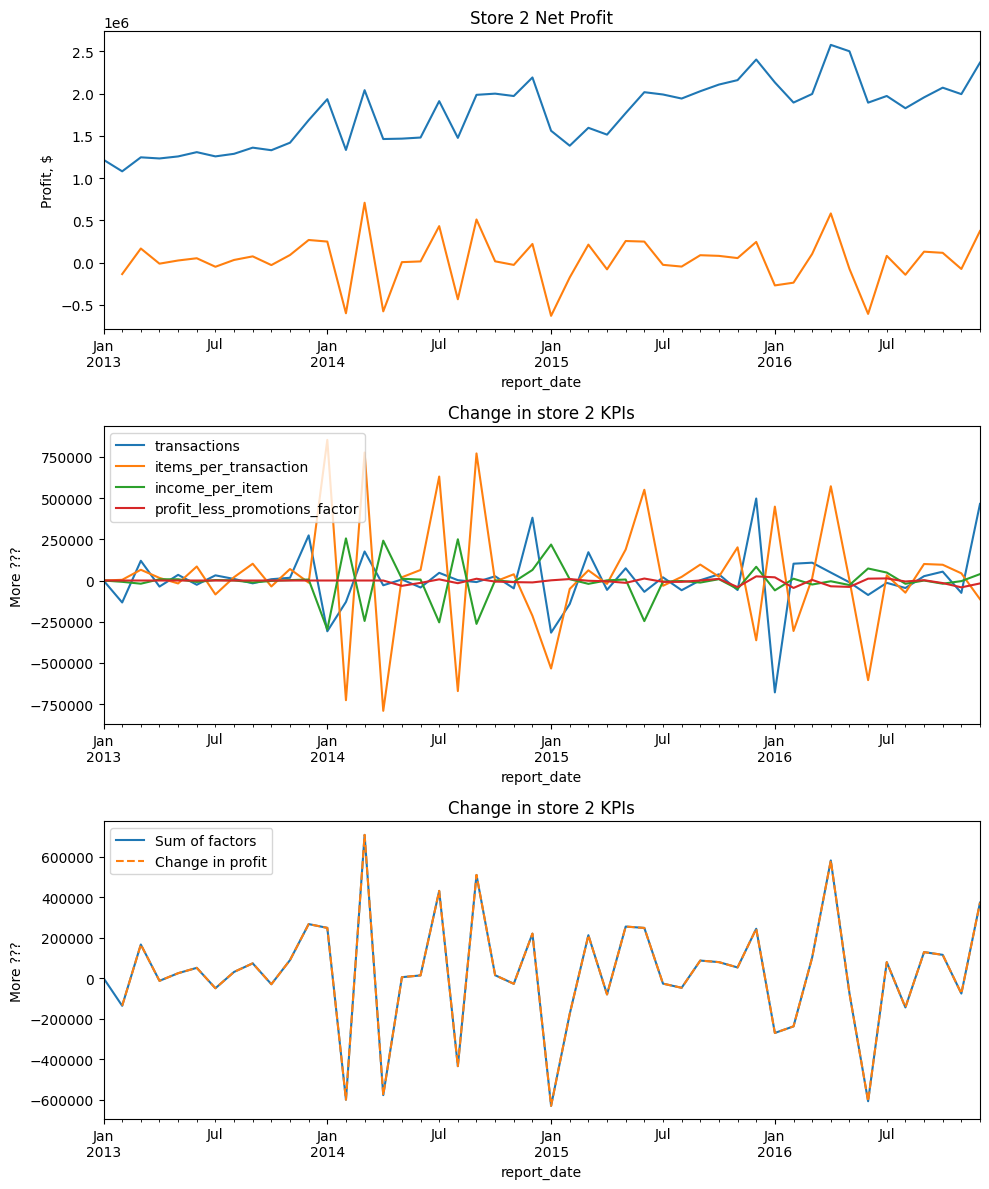

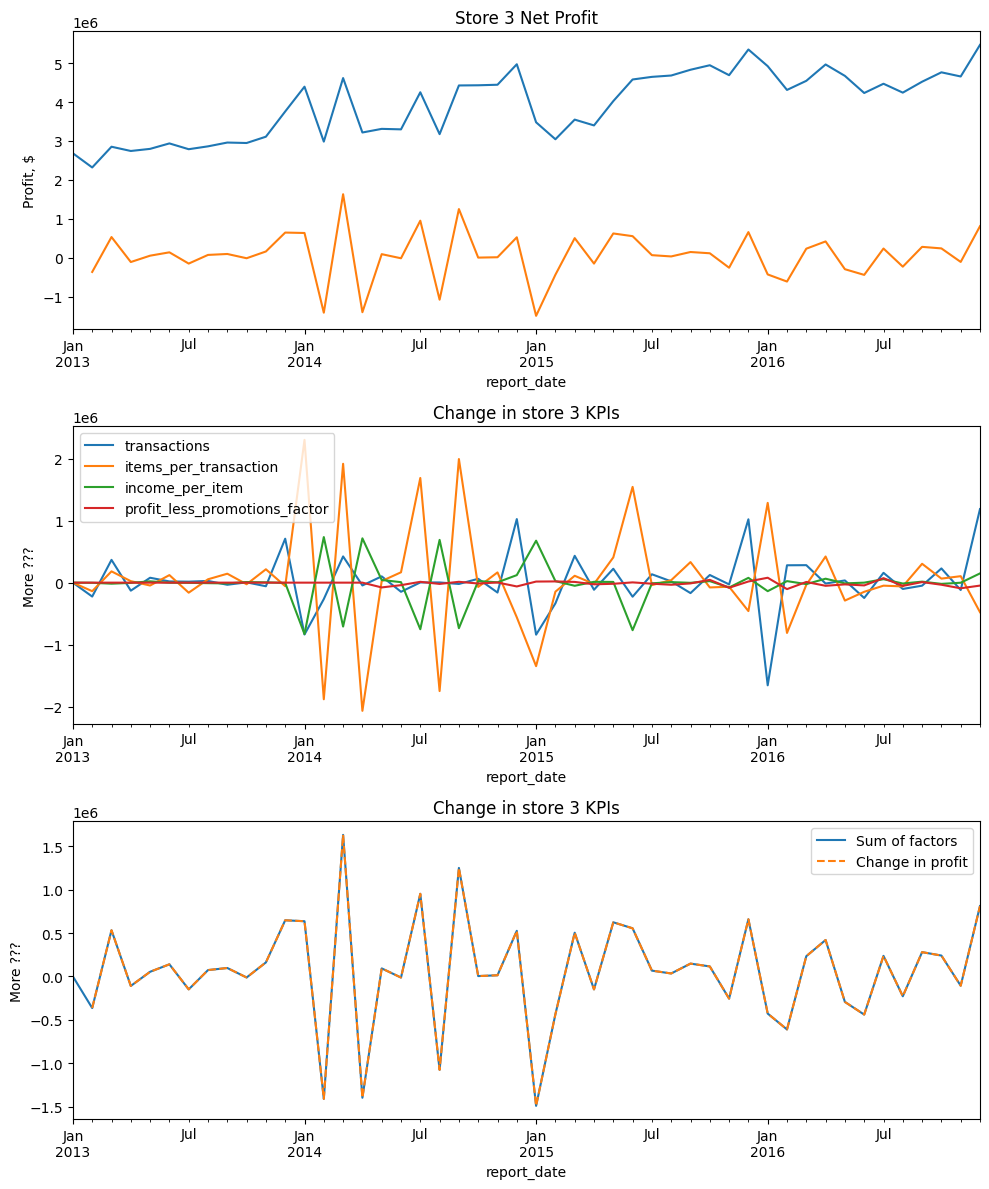

In [12]:
from pyparsing import line
from key_driver_analysis import decompose_funnel_metrics

df_metrics = decompose_funnel_metrics(
    df_sales, "report_date", ["store_nbr"], funnel_cols
)

for store in range(1, 4):
    fig, ax = plt.subplots(3, 1, figsize=(10, 12))
    tmp = df_sales[df_sales.store_nbr == store].set_index("report_date")
    tmp2 = df_metrics[df_metrics.store_nbr == store].set_index("report_date")

    ax[0].set_title(f"Store {store} Net Profit")
    ax[0].set_ylabel("Profit, $")
    tmp["net_profit"].plot(ax=ax[0])
    tmp["net_profit"].diff().plot(ax=ax[0], label="Change in profit")

    ax[1].set_title(f"Change in store {store} KPIs")
    ax[1].set_ylabel("More ???")
    tmp2[funnel_cols].plot(ax=ax[1])

    ax[2].set_title(f"Change in store {store} KPIs")
    ax[2].set_ylabel("More ???")
    tmp2[funnel_cols].sum(axis=1).plot(ax=ax[2], label="Sum of factors")
    tmp["net_profit"].diff().plot(ax=ax[2], label="Change in profit", linestyle="--")
    ax[2].legend()

    fig.tight_layout()
    plt.show()